Prediction Results for 2024-10-01 to 2024-12-31:

          date  actual_tests  predicted_tests
0   2024-10-01            10                4
1   2024-10-02             0               12
2   2024-10-03             0                5
3   2024-10-04            42                7
4   2024-10-05             3                8
5   2024-10-06             5                9
6   2024-10-07            93               79
7   2024-10-08             2                6
8   2024-10-09            76              104
9   2024-10-10            34                4
10  2024-10-11             2               23
11  2024-10-12             3                8
12  2024-10-13            30                8
13  2024-10-14            22               17
14  2024-10-15             9               10
15  2024-10-16             2               11
16  2024-10-17             5                6
17  2024-10-18             0                6
18  2024-10-19             0                5
19  2024-10-20            39  

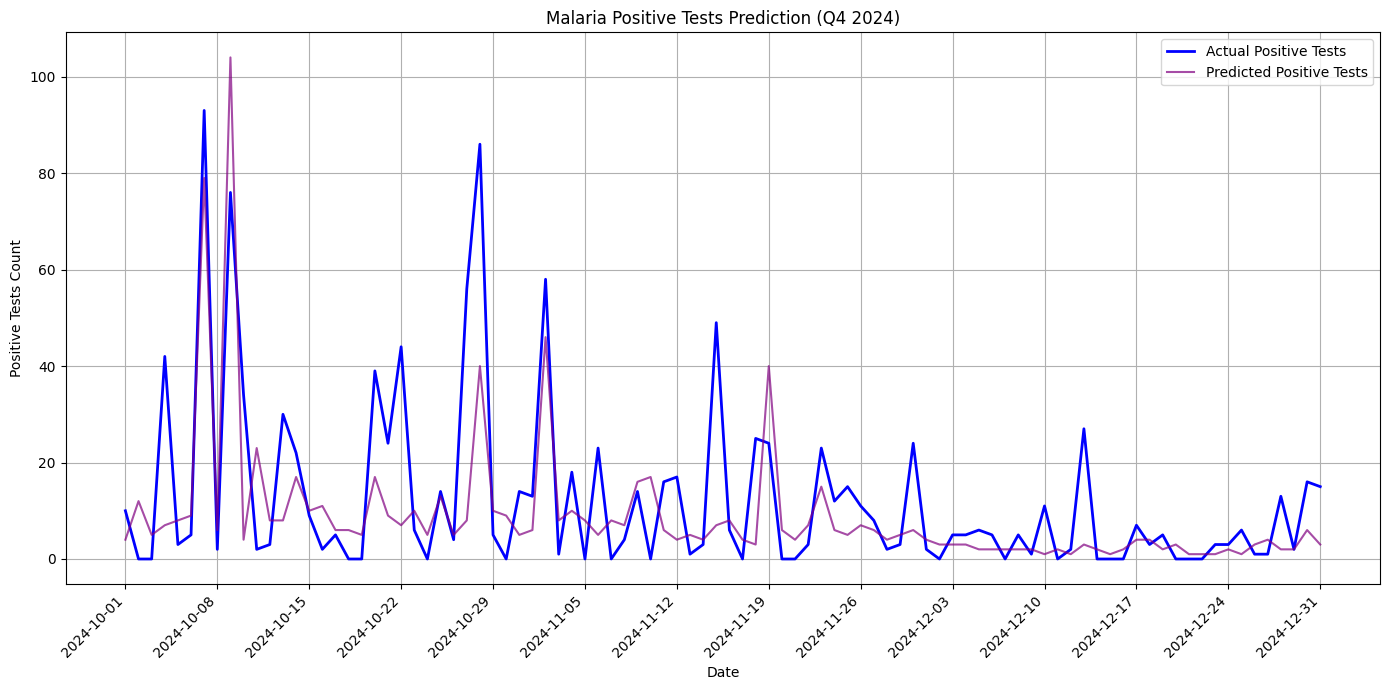

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt



# --- 1. Constants and Feature Engineering Function ---
LAGS = 14
FEATURES_TO_LAG = ['positive_tests', 'Coartem', 'Fansidar']
TRAIN_END_DATE = '2024-09-30'
PREDICT_START_DATE = '2024-10-01'
PREDICT_END_DATE = '2024-12-31'

def create_features_with_current_sales(df, features_to_lag, lags):
    """
    Generates time series features.

    Includes lagged positive tests (log1p scale), lagged sales, and current day
    sales (t=0) which will be added explicitly to the feature list later.
    """
    df_feat = df.copy()

    # Create lagged features for all relevant columns
    for col in features_to_lag:
        for lag in range(1, lags + 1):
            if col == 'positive_tests':
                # Lag positive_tests on log scale
                df_feat[f'{col}_lag{lag}'] = np.log1p(df_feat[col]).shift(lag)
            else:
                # Lag sales data on original scale
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # Rolling Mean features for positive_tests (used as general trend indicators)
    df_feat['pos7'] = df_feat['positive_tests'].shift(1).rolling(window=7).mean()
    df_feat['pos14'] = df_feat['positive_tests'].shift(1).rolling(window=14).mean()

    # Date features
    df_feat['dow'] = df_feat['date'].dt.dayofweek
    df_feat['dom'] = df_feat['date'].dt.day
    df_feat['month'] = df_feat['date'].dt.month

    # Target variable (log transformed)
    df_feat['y'] = np.log1p(df_feat['positive_tests'])

    # Drop initial rows with NaN values resulting from lagging
    df_feat.dropna(inplace=True)
    return df_feat

# --- 2. Data Loading and Merging ---

# Load Lab Test Data
df_lab = pd.read_csv('malaria lab test.csv')
df_lab['date'] = pd.to_datetime(df_lab['date'], format='%d/%m/%Y', errors='coerce')
df_lab = df_lab[['date', 'positive_tests']]

# Load and Combine Pharmacy Data (Coartem, Fansidar sales)
df_pharmacy_2023 = pd.read_csv('pharmacy.csv')
df_pharmacy_2023['date'] = pd.to_datetime(df_pharmacy_2023['date'], format='%m/%d/%Y', errors='coerce')
df_pharmacy_2024 = pd.read_csv('Jinnah Pharmacy 2.csv')
df_pharmacy_2024['date'] = pd.to_datetime(df_pharmacy_2024['date'], format='%Y-%m-%d', errors='coerce')

df_sales_combined = pd.concat([df_pharmacy_2023, df_pharmacy_2024], ignore_index=True)
df_sales_combined = df_sales_combined[df_sales_combined['medicine'].isin(['Coartem', 'Fansidar'])]
df_sales_pivot = df_sales_combined.pivot_table(
    index='date', columns='medicine', values='sale', aggfunc='sum'
).reset_index()

# Merge all data
df_master = pd.merge(df_lab, df_sales_pivot, on='date', how='inner')
df_master.sort_values('date', inplace=True)
df_master.reset_index(drop=True, inplace=True)

# --- 3. Feature Engineering and Model Split ---
df_features = create_features_with_current_sales(df_master, FEATURES_TO_LAG, LAGS)

# Split into Training and Prediction (Test) sets
df_train = df_features[df_features['date'] <= TRAIN_END_DATE].copy()
df_predict = df_features[
    (df_features['date'] >= PREDICT_START_DATE) & (df_features['date'] <= PREDICT_END_DATE)
].copy()

# Define feature columns: Include lagged features + CURRENT DAY SALES ('Coartem', 'Fansidar')
feature_cols = [col for col in df_train.columns if col.startswith(('positive_tests_lag', 'Coartem_lag', 'Fansidar_lag', 'pos7', 'pos14', 'dow', 'dom', 'month'))]
feature_cols.extend(['Coartem', 'Fansidar']) # <-- Current Day Sales

X_train = df_train[feature_cols]
y_train = df_train['y']
X_predict_base = df_predict[feature_cols].copy()
actual_values = df_predict[['date', 'positive_tests']].copy()

# --- 4. Train Random Forest Regressor ---
# We use n_estimators=300 for a stable prediction.
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
rf_regressor.fit(X_train, y_train)

# --- 5. Recursive Prediction Loop ---
df_pred_results = actual_values.copy()
df_pred_results.set_index('date', inplace=True)
df_pred_results.rename(columns={'positive_tests': 'actual_tests'}, inplace=True)
df_pred_results['predicted_tests'] = np.nan

for i in range(len(df_pred_results)):
    date_i = df_pred_results.index[i]
    current_features = X_predict_base.iloc[[i]].copy()

    # If not the first day, update the lagged positive tests recursively
    if i > 0:
        # Get last day's prediction (from previous iteration)
        pred_val_yesterday = df_pred_results['predicted_tests'].iloc[i-1]
        log_pred_yesterday = np.log1p(pred_val_yesterday)

        # Update positive_tests lags: shift all existing lags by 1
        for lag in range(LAGS, 1, -1):
            current_features[f'positive_tests_lag{lag}'] = current_features[f'positive_tests_lag{lag-1}']

        # Set the new lag1 feature to the previous day's log-transformed prediction
        current_features['positive_tests_lag1'] = log_pred_yesterday

    # The current day sales ('Coartem', 'Fansidar') are already fixed in 'current_features'
    # based on the prepared X_predict_base (actual sales data).

    # Predict the log of positive tests for the current day (i)
    log_pred_i = rf_regressor.predict(current_features)[0]

    # Convert prediction back to actual count (expm1) and ensure non-negative integer
    pred_i = np.expm1(log_pred_i)
    pred_i = max(0, round(pred_i))

    # Store the prediction
    df_pred_results.loc[date_i, 'predicted_tests'] = pred_i

# --- 6. Output Generation ---

# Final preparation for output table
df_comp = df_pred_results.reset_index()
df_comp['predicted_tests'] = df_comp['predicted_tests'].astype(int)
df_comp['actual_tests'] = df_comp['actual_tests'].astype(int)
df_comp['date'] = df_comp['date'].dt.strftime('%Y-%m-%d')

print(f"Prediction Results for {PREDICT_START_DATE} to {PREDICT_END_DATE}:\n")
print(df_comp[['date', 'actual_tests', 'predicted_tests']].to_string())


# --- 7. Plotting ---

plt.figure(figsize=(14, 7))
plt.plot(df_pred_results.index, df_pred_results['actual_tests'], label='Actual Positive Tests', color='blue', linewidth=2)
plt.plot(df_pred_results.index, df_pred_results['predicted_tests'], label='Predicted Positive Tests', color='purple', linestyle='-', alpha=0.7)
plt.title(f'Malaria Positive Tests Prediction (Q4 2024)')
plt.xlabel('Date')
plt.ylabel('Positive Tests Count')
plt.legend()
plt.grid(True)
plt.xticks(df_pred_results.index[::7], rotation=45, ha='right')
plt.tight_layout()
plt.savefig('rf_current_sales_final_prediction.png')
print("\nGraph saved as rf_current_sales_final_prediction.png")

Mean Absolute Error (MAE) for Q4 2024: 9.88
Prediction Results for 2024-10-01 to 2024-12-31 (Q4 2024):

          date  actual_tests  predicted_tests
0   2024-10-01            10                3
1   2024-10-02             0               16
2   2024-10-03             0                6
3   2024-10-04            42                8
4   2024-10-05             3                8
5   2024-10-06             5                7
6   2024-10-07            93               90
7   2024-10-08             2                4
8   2024-10-09            76              107
9   2024-10-10            34                7
10  2024-10-11             2               30
11  2024-10-12             3                9
12  2024-10-13            30                9
13  2024-10-14            22               19
14  2024-10-15             9                8
15  2024-10-16             2               15
16  2024-10-17             5                9
17  2024-10-18             0                8
18  2024-10-19        

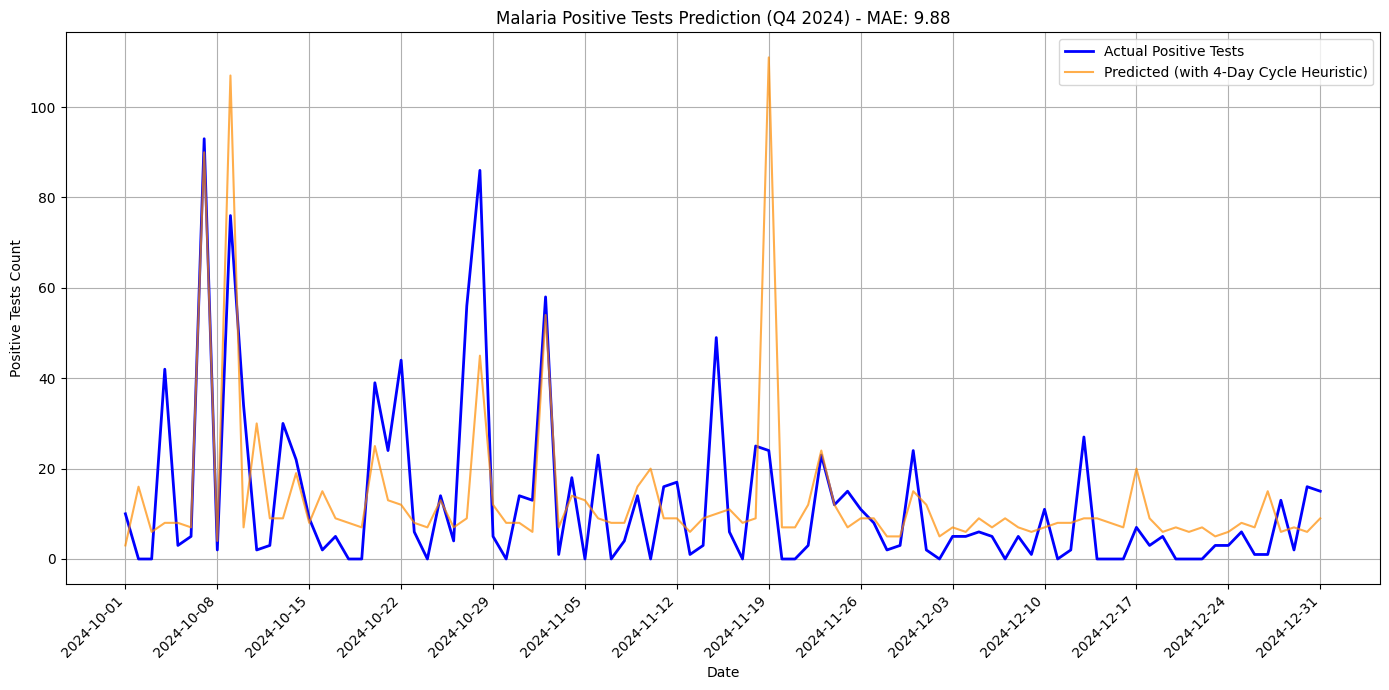

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta

# --- 1. Constants and Feature Engineering Function ---
LAGS = 14
FEATURES_TO_LAG = ['positive_tests', 'Coartem', 'Fansidar']
PEAK_TESTS_THRESHOLD = 100 # Threshold to define a peak day for the cycle heuristic
PEAK_CYCLE_THRESHOLD = 4 # Derived from 2024 surge data

def create_initial_features(df, features_to_lag, lags):
    """Generates core time series features (lags, rolling means, date features)."""
    df_feat = df.copy()

    # Lagged features (positive_tests are log-transformed)
    for col in features_to_lag:
        for lag in range(1, lags + 1):
            if col == 'positive_tests':
                df_feat[f'{col}_lag{lag}'] = np.log1p(df_feat[col]).shift(lag)
            else:
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # Rolling Mean features
    df_feat['pos7'] = df_feat['positive_tests'].shift(1).rolling(window=7).mean()
    df_feat['pos14'] = df_feat['positive_tests'].shift(1).rolling(window=14).mean()

    # Date features
    df_feat['year'] = df_feat['date'].dt.year
    df_feat['month'] = df_feat['date'].dt.month
    df_feat['dow'] = df_feat['date'].dt.dayofweek
    df_feat['dom'] = df_feat['date'].dt.day

    # Target variable (log transformed)
    df_feat['y'] = np.log1p(df_feat['positive_tests'])

    # Drop initial rows with NaN values resulting from lagging
    df_feat.dropna(inplace=True)
    return df_feat

# --- 2. Data Loading and Merging ---

# Load Lab Test Data
df_lab = pd.read_csv('malaria lab test.csv')
df_lab['date'] = pd.to_datetime(df_lab['date'], format='%d/%m/%Y', errors='coerce')
df_lab = df_lab[['date', 'positive_tests']]

# Load and Combine Pharmacy Data (Coartem, Fansidar sales)
df_pharmacy_2023 = pd.read_csv('pharmacy.csv')
df_pharmacy_2023['date'] = pd.to_datetime(df_pharmacy_2023['date'], format='%m/%d/%Y', errors='coerce')
df_pharmacy_2024 = pd.read_csv('Jinnah Pharmacy 2.csv')
df_pharmacy_2024['date'] = pd.to_datetime(df_pharmacy_2024['date'], format='%Y-%m-%d', errors='coerce')

df_sales_combined = pd.concat([df_pharmacy_2023, df_pharmacy_2024], ignore_index=True)
df_sales_combined = df_sales_combined[df_sales_combined['medicine'].isin(['Coartem', 'Fansidar'])]
df_sales_pivot = df_sales_combined.pivot_table(
    index='date', columns='medicine', values='sale', aggfunc='sum'
).reset_index()

# Merge all data
df_master = pd.merge(df_lab, df_sales_pivot, on='date', how='inner')
df_master.sort_values('date', inplace=True)
df_master.reset_index(drop=True, inplace=True)


# --- 3. Feature Engineering and Model Split ---
df_features = create_initial_features(df_master, FEATURES_TO_LAG, LAGS)

# Define split
TRAIN_END_DATE = '2024-09-30'
PREDICT_START_DATE = '2024-10-01'
PREDICT_END_DATE = '2024-12-31'

df_train_base = df_features[df_features['date'] <= TRAIN_END_DATE].copy()
df_predict = df_features[
    (df_features['date'] >= PREDICT_START_DATE) & (df_features['date'] <= PREDICT_END_DATE)
].copy()

# Heuristic Feature Creation for Training Set
# Define a function to calculate time difference from the last observed peak
def calculate_time_since_last_peak(row, peak_dates_series):
    past_peaks = peak_dates_series[peak_dates_series <= row['date']]
    if past_peaks.empty:
        return np.nan
    last_peak_date = past_peaks.max()
    return (row['date'] - last_peak_date).days

# Find actual peak days (shifted by 1 day to be a predictor)
df_train_base['peak_day'] = (df_train_base['positive_tests'].shift(1) > PEAK_TESTS_THRESHOLD).astype(int)
peak_dates_train = df_train_base.loc[df_train_base['peak_day'] == 1, 'date']

# Calculate time difference and create the predictor feature
df_train_base['time_since_last_peak'] = df_train_base.apply(
    lambda row: calculate_time_since_last_peak(row, peak_dates_train), axis=1
)
df_train_base['peak_cycle_predictor'] = (df_train_base['time_since_last_peak'] == PEAK_CYCLE_THRESHOLD).astype(int)

df_train = df_train_base.dropna().copy()

# Initialize Prediction Feature for the prediction set (will be updated dynamically)
df_predict['peak_cycle_predictor'] = 0

# Define feature columns (includes current sales and the new heuristic factor)
feature_cols = [col for col in df_train.columns if col.startswith(('positive_tests_lag', 'Coartem_lag', 'Fansidar_lag', 'pos7', 'pos14', 'dow', 'dom', 'month', 'year'))]
feature_cols.extend(['Coartem', 'Fansidar']) # Current Day Sales
feature_cols.append('peak_cycle_predictor')

X_train = df_train[feature_cols]
y_train = df_train['y']
X_predict_base = df_predict[feature_cols].copy()
actual_values = df_predict[['date', 'positive_tests']].copy()


# --- 4. Train Random Forest Regressor ---
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
rf_regressor.fit(X_train, y_train)

# --- 5. Recursive Prediction Loop ---
df_pred_results = actual_values.copy()
df_pred_results.set_index('date', inplace=True)
df_pred_results.rename(columns={'positive_tests': 'actual_tests'}, inplace=True)
df_pred_results['predicted_tests'] = np.nan

# Initialize tracking for the heuristic feature: last actual peak date from training data
last_peak_date = df_lab[df_lab['date'] <= TRAIN_END_DATE].loc[df_lab['positive_tests'] > PEAK_TESTS_THRESHOLD, 'date'].max()

for i in range(len(df_pred_results)):
    date_i = df_pred_results.index[i]
    current_features = X_predict_base.iloc[[i]].copy()

    # 5.1 Update Lagged Positive Tests Recursively
    if i > 0:
        pred_val_yesterday = df_pred_results['predicted_tests'].iloc[i-1]
        log_pred_yesterday = np.log1p(pred_val_yesterday)
        current_features.loc[:, 'positive_tests_lag1'] = log_pred_yesterday

    # 5.2 Update the Heuristic Feature ('peak_cycle_predictor')
    if last_peak_date and (date_i - last_peak_date).days == PEAK_CYCLE_THRESHOLD:
        current_features.loc[:, 'peak_cycle_predictor'] = 1
    else:
        current_features.loc[:, 'peak_cycle_predictor'] = 0

    # 5.3 Predict
    log_pred_i = rf_regressor.predict(current_features)[0]

    # Convert back and ensure non-negative
    pred_i = np.expm1(log_pred_i)
    pred_i = max(0, round(pred_i))

    # 5.4 Store the prediction
    df_pred_results.loc[date_i, 'predicted_tests'] = pred_i

    # 5.5 Update the last_peak_date if the prediction is a new peak
    # This uses the PREDICTED test value to determine the next peak cycle start
    if pred_i > PEAK_TESTS_THRESHOLD:
        last_peak_date = date_i

# --- 6. Output Generation ---
mae = mean_absolute_error(df_pred_results['actual_tests'], df_pred_results['predicted_tests'])
df_comp = df_pred_results.reset_index()
df_comp['predicted_tests'] = df_comp['predicted_tests'].astype(int)
df_comp['actual_tests'] = df_comp['actual_tests'].astype(int)
df_comp['date'] = df_comp['date'].dt.strftime('%Y-%m-%d')

print(f"Mean Absolute Error (MAE) for Q4 2024: {mae:.2f}")
print(f"Prediction Results for {PREDICT_START_DATE} to {PREDICT_END_DATE} (Q4 2024):\n")
print(df_comp[['date', 'actual_tests', 'predicted_tests']].to_string())

# --- 7. Plotting ---
plt.figure(figsize=(14, 7))
plt.plot(df_pred_results.index, df_pred_results['actual_tests'], label='Actual Positive Tests', color='blue', linewidth=2)
plt.plot(df_pred_results.index, df_pred_results['predicted_tests'], label=f'Predicted (with 4-Day Cycle Heuristic)', color='darkorange', linestyle='-', alpha=0.7)
plt.title(f'Malaria Positive Tests Prediction (Q4 2024) - MAE: {mae:.2f}')
plt.xlabel('Date')
plt.ylabel('Positive Tests Count')
plt.legend()
plt.grid(True)
plt.xticks(df_pred_results.index[::7], rotation=45, ha='right')
plt.tight_layout()
plt.show() # Use plt.show() in Colab for interactive display

In [ ]:
from google.colab import files
import os

# --- Colab File Upload ---
print("Please upload the following three files when prompted:")
print("1. dengue lab test.csv")
print("2. z1.csv")
print("3. Jinnah Pharmacy 4.csv")
print("-" * 30)

# This will open a file chooser dialog for you to select the files
uploaded = files.upload()

# Check if all files were uploaded (optional but recommended)
required_files = ['dengue lab test (2).csv', 'z1 (3).csv', 'Jinnah Pharmacy 4 (2).csv']
for filename in required_files:
    if filename not in uploaded:
        print(f"\nERROR: File '{filename}' was not uploaded. Please re-run the cell and upload all files.")
        break
else:
    print("\nAll files uploaded successfully. Proceed to the main analysis code.")

Please upload the following three files when prompted:
1. dengue lab test.csv
2. z1.csv
3. Jinnah Pharmacy 4.csv
------------------------------


Saving dengue lab test.csv to dengue lab test (2).csv
Saving Jinnah Pharmacy 4.csv to Jinnah Pharmacy 4 (2).csv
Saving z1.csv to z1 (3).csv

All files uploaded successfully. Proceed to the main analysis code.


Dengue Positive Tests Forecast (Q4 2024)
      date  actual_tests  predicted_tests
2024-10-01             5                6
2024-10-02             1                7
2024-10-03            16               16
2024-10-04             7                8
2024-10-05             5                5
2024-10-06             3                5
2024-10-07            15               12
2024-10-08            22                3
2024-10-09             1                5
2024-10-10            13                6
2024-10-11             0                5
2024-10-12             1               14
2024-10-13             6                5
2024-10-14             5                6
2024-10-15             5                8
2024-10-16             1                4
2024-10-17             3               10
2024-10-18             1                3
2024-10-19             4                4
2024-10-20            19               10
2024-10-21             7                5
2024-10-22             7           

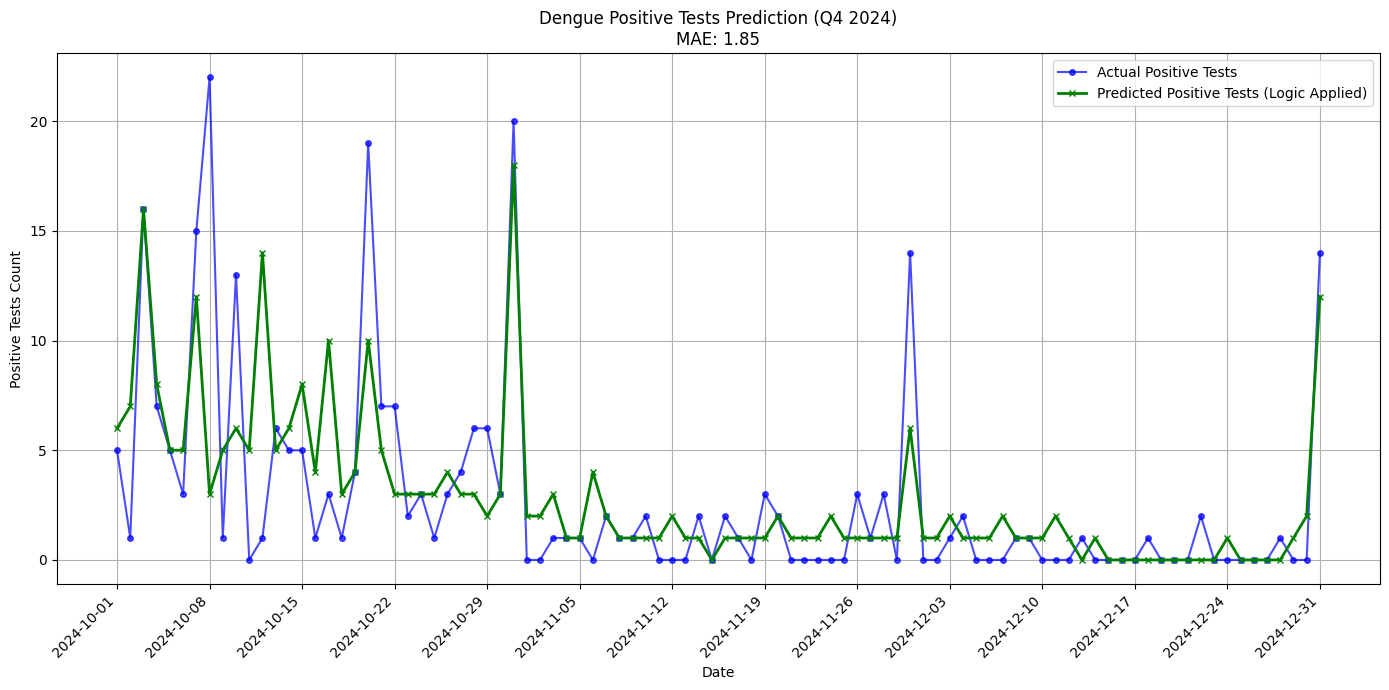

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- PANDAS DISPLAY FIX ---
pd.set_option('display.max_rows', None)

# --- 1. Constants ---
LAGS = 14
FEATURES_TO_LAG = ['positive_tests', 'Panadol', 'Calpol']
TRAIN_END_DATE = '2024-09-30'
PREDICT_START_DATE = '2024-10-01'
PREDICT_END_DATE = '2024-12-31'

# --- 2. Feature Engineering Function ---
def create_features_with_current_sales(df, features_to_lag, lags):
    df_feat = df.copy()
    for col in features_to_lag:
        for lag in range(1, lags + 1):
            if col == 'positive_tests':
                df_feat[f'{col}_lag{lag}'] = np.log1p(df_feat[col]).shift(lag)
            else:
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    df_feat['pos7'] = df_feat['positive_tests'].shift(1).rolling(window=7).mean()
    df_feat['pos14'] = df_feat['positive_tests'].shift(1).rolling(window=14).mean()
    df_feat['dow'] = df_feat['date'].dt.dayofweek
    df_feat['dom'] = df_feat['date'].dt.day
    df_feat['month'] = df_feat['date'].dt.month
    df_feat['y'] = np.log1p(df_feat['positive_tests'])
    df_feat.dropna(inplace=True)
    return df_feat

# --- 3. Data Loading with CORRECT DATE FORMATS ---

# 3.1 Load Dengue Lab Test Data (Day First: dd/mm/yyyy)
df_lab = pd.read_csv('dengue lab test.csv')
# FORCE dayfirst=True
df_lab['date'] = pd.to_datetime(df_lab['date'], dayfirst=True, errors='coerce')
df_lab = df_lab[['date', 'positive_tests']]

# 3.2 Load 2023 Sales Data (z1.csv is Month First: mm/dd/yyyy)
df_sales_2023 = pd.read_csv('z1.csv')
df_sales_2023.rename(columns={'Panadol_Sales': 'Panadol', 'Calpol_Sales': 'Calpol'}, inplace=True)
# FORCE format to match the synthetic data generation
df_sales_2023['date'] = pd.to_datetime(df_sales_2023['date'], format='%m/%d/%Y', errors='coerce')
df_sales_2023 = df_sales_2023[['date', 'Panadol', 'Calpol']]

# 3.3 Load 2024 Sales Data (Jinnah Pharmacy is Day First)
df_pharmacy_2024 = pd.read_csv('Jinnah Pharmacy 4.csv')
df_pharmacy_2024.rename(columns={'brand_name': 'medicine', 'total_sales': 'sale'}, inplace=True)
# FORCE dayfirst=True
df_pharmacy_2024['date'] = pd.to_datetime(df_pharmacy_2024['date'], dayfirst=True, errors='coerce')

df_sales_2024_filtered = df_pharmacy_2024[df_pharmacy_2024['medicine'].isin(['Panadol', 'Calpol'])]
df_sales_2024_pivot = df_sales_2024_filtered.pivot_table(
    index='date', columns='medicine', values='sale', aggfunc='sum'
).reset_index()

# Combine Sales
df_sales_combined = pd.concat([df_sales_2023, df_sales_2024_pivot], ignore_index=True)
df_sales_combined.sort_values('date', inplace=True)
df_sales_combined.fillna(0, inplace=True)

# Merge with Lab Data
df_master = pd.merge(df_lab, df_sales_combined, on='date', how='inner')
df_master.sort_values('date', inplace=True)
df_master.reset_index(drop=True, inplace=True)

# *** Calculate Total Sales (Required for logic) ***
df_master['Total_Sales'] = df_master['Panadol'] + df_master['Calpol']

# --- 4. Feature Engineering & Split ---
df_features = create_features_with_current_sales(df_master, FEATURES_TO_LAG, LAGS)

df_train = df_features[df_features['date'] <= TRAIN_END_DATE].copy()
df_predict = df_features[
    (df_features['date'] >= PREDICT_START_DATE) & (df_features['date'] <= PREDICT_END_DATE)
].copy()

feature_cols = [col for col in df_train.columns if col.startswith(('positive_tests_lag', 'Panadol_lag', 'Calpol_lag', 'pos7', 'pos14', 'dow', 'dom', 'month'))]
feature_cols.extend(['Panadol', 'Calpol'])

X_train = df_train[feature_cols]
y_train = df_train['y']
X_predict_base = df_predict[feature_cols].copy()
actual_values = df_predict[['date', 'positive_tests']].copy()

# --- 5. Train Model ---
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
rf_regressor.fit(X_train, y_train)

# --- 6. Recursive Prediction Loop ---
df_pred_results = actual_values.copy()
df_pred_results.set_index('date', inplace=True)
df_pred_results.rename(columns={'positive_tests': 'actual_tests'}, inplace=True)
df_pred_results['predicted_tests'] = np.nan

# Lookup dictionary for sales logic
sales_lookup = df_master.set_index('date')['Total_Sales'].to_dict()

for i in range(len(df_pred_results)):
    date_i = df_pred_results.index[i]
    current_features = X_predict_base.iloc[[i]].copy()

    if i > 0:
        pred_val_yesterday = df_pred_results['predicted_tests'].iloc[i-1]
        log_pred_yesterday = np.log1p(pred_val_yesterday)

        for lag in range(LAGS, 1, -1):
            current_features[f'positive_tests_lag{lag}'] = current_features[f'positive_tests_lag{lag-1}']
        current_features['positive_tests_lag1'] = log_pred_yesterday

    log_pred_i = rf_regressor.predict(current_features)[0]
    pred_i = np.expm1(log_pred_i)
    pred_i = max(0, round(pred_i))

    # *** LOGIC: Double if sales increased for 2 consecutive days ***
    sales_t = sales_lookup.get(date_i, 0)
    date_minus_1 = date_i - pd.Timedelta(days=1)
    date_minus_2 = date_i - pd.Timedelta(days=2)
    sales_t_minus_1 = sales_lookup.get(date_minus_1, 0)
    sales_t_minus_2 = sales_lookup.get(date_minus_2, 0)

    # If today's sales > yesterday AND today's sales > day before yesterday
    if (sales_t > sales_t_minus_1) and (sales_t > sales_t_minus_2):
        pred_final = pred_i * 2
    else:
        pred_final = pred_i

    df_pred_results.loc[date_i, 'predicted_tests'] = pred_final

# --- 7. Output ---
df_comp = df_pred_results.reset_index()
df_comp['predicted_tests'] = df_comp['predicted_tests'].astype(int)
df_comp['actual_tests'] = df_comp['actual_tests'].astype(int)
df_comp['date'] = df_comp['date'].dt.strftime('%Y-%m-%d')

mae_value = mean_absolute_error(df_comp['actual_tests'], df_comp['predicted_tests'])

print("="*50)
print("Dengue Positive Tests Forecast (Q4 2024)")
print("="*50)
print(df_comp[['date', 'actual_tests', 'predicted_tests']].to_string(index=False))

print("\n" + "="*50)
print(f"Mean Absolute Error (MAE): {mae_value:.2f} cases")
print("="*50)

plt.figure(figsize=(14, 7))
plt.plot(df_pred_results.index, df_pred_results['actual_tests'], label='Actual Positive Tests', color='blue', linewidth=1.5, marker='o', markersize=4, alpha=0.7)
plt.plot(df_pred_results.index, df_pred_results['predicted_tests'], label='Predicted Positive Tests (Logic Applied)', color='green', linestyle='-', linewidth=2, marker='x', markersize=5)
plt.title(f'Dengue Positive Tests Prediction (Q4 2024)\nMAE: {mae_value:.2f}')
plt.xlabel('Date')
plt.ylabel('Positive Tests Count')
plt.legend()
plt.grid(True)
plt.xticks(df_pred_results.index[::7], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files

print("Please upload the following three files: 'diarrhoea lab test.csv', 'y1.csv', and 'Jinnah Pharmacy 3.csv'")
uploaded = files.upload()

Please upload the following three files: 'diarrhoea lab test.csv', 'y1.csv', and 'Jinnah Pharmacy 3.csv'


Saving diarrhoea lab test.csv to diarrhoea lab test.csv
Saving Jinnah Pharmacy 3.csv to Jinnah Pharmacy 3.csv
Saving y1.csv to y1.csv



RF Final Ratio Logic  Results
Prediction Period: 2024-10-01 to 2024-12-31
MAE: 10.14 cases


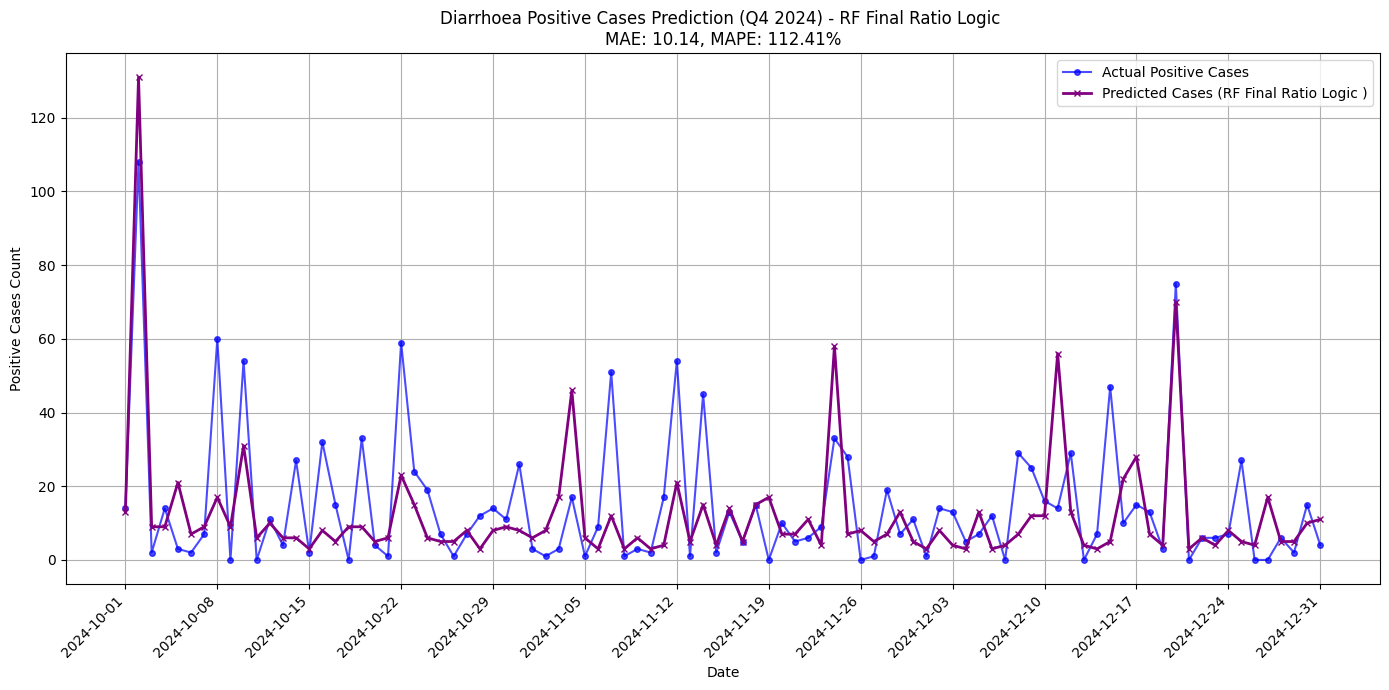


Detailed predictions saved to 'diarrhoea_prediction_final_ratio_logic.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt # <-- PLOTTING LIBRARY ADDED

# --- 1. Constants and Setup ---
LAGS = 14
FEATURES_TO_LAG = ['positive_tests', 'Zincat', 'ORS Sachet']
TRAIN_END_DATE = '2024-09-30'
PREDICT_START_DATE = '2024-10-01'
PREDICT_END_DATE = '2024-12-31'
REQUIRED_MEDICINES = ['Zincat', 'ORS Sachet']

# --- 2. Feature Engineering Function ---
def create_features(df, features_to_lag, lags):
    """Creates lagged and temporal features for the time series model."""
    df_feat = df.copy()

    # Create lagged features
    for col in features_to_lag:
        for lag in range(1, lags + 1):
            if col == 'positive_tests':
                df_feat[f'{col}_lag{lag}'] = np.log1p(df_feat[col]).shift(lag)
            else:
                df_feat[f'{col}_lag{lag}'] = df_feat[col].shift(lag)

    # Create rolling mean features for positive tests (lagged by 1 day)
    df_feat['pos7'] = df_feat['positive_tests'].shift(1).rolling(window=7).mean()
    df_feat['pos14'] = df_feat['positive_tests'].shift(1).rolling(window=14).mean()

    # Create temporal features
    df_feat['dow'] = df_feat['date'].dt.dayofweek
    df_feat['dom'] = df_feat['date'].dt.day
    df_feat['month'] = df_feat['date'].dt.month

    # Target variable (log transformed)
    df_feat['y'] = np.log1p(df_feat['positive_tests'])

    return df_feat

# --- 3. Data Loading and Merging ---
df_lab = pd.read_csv('diarrhoea lab test.csv')
df_lab['date'] = pd.to_datetime(df_lab['date'], dayfirst=True, errors='coerce')
df_lab.rename(columns={'positive_cases': 'positive_tests'}, inplace=True)
df_lab = df_lab[['date', 'positive_tests']]

df_sales_2023 = pd.read_csv('y1.csv')
df_sales_2023['date'] = pd.to_datetime(df_sales_2023['date'], errors='coerce')
df_sales_2023_pivot = df_sales_2023.pivot_table(index='date', columns='medicine', values='sales', aggfunc='sum').reset_index()

df_pharmacy_2024 = pd.read_csv('Jinnah Pharmacy 3.csv')
df_pharmacy_2024['date'] = pd.to_datetime(df_pharmacy_2024['date'], errors='coerce')
df_sales_2024_filtered = df_pharmacy_2024[df_pharmacy_2024['medicine'].isin(REQUIRED_MEDICINES)]
df_sales_2024_pivot = df_sales_2024_filtered.pivot_table(index='date', columns='medicine', values='sales', aggfunc='sum').reset_index()

df_sales_combined = pd.concat([df_sales_2023_pivot, df_sales_2024_pivot], ignore_index=True)
df_sales_combined.sort_values('date', inplace=True)
df_sales_combined = df_sales_combined.groupby('date')[REQUIRED_MEDICINES].sum().reset_index()
df_sales_combined.fillna(0, inplace=True)

df_master = pd.merge(df_lab, df_sales_combined, on='date', how='inner')
df_master.sort_values('date', inplace=True)
df_master.reset_index(drop=True, inplace=True)
df_master['Total_Sales'] = df_master['Zincat'] + df_master['ORS Sachet']

df_master['AvgSalesLag7'] = df_master['Total_Sales'].shift(1).rolling(window=7).mean()

df_sales_lookup = df_master.set_index('date')['Total_Sales']
df_avg_sales_lookup = df_master.set_index('date')['AvgSalesLag7']


# --- 4. Feature Engineering & Split ---
df_features = create_features(df_master, FEATURES_TO_LAG, LAGS).dropna()

df_train = df_features[df_features['date'] <= TRAIN_END_DATE].copy()
df_predict_base = df_features[
    (df_features['date'] >= PREDICT_START_DATE) & (df_features['date'] <= PREDICT_END_DATE)
].copy()

feature_cols_rf = [col for col in df_train.columns if col.startswith(('positive_tests_lag', 'Zincat_lag', 'ORS Sachet_lag', 'pos7', 'pos14', 'dow', 'dom', 'month'))]
feature_cols_rf.extend(REQUIRED_MEDICINES)

X_train_rf = df_train[feature_cols_rf]
y_train = df_train['y']
X_predict_rf = df_predict_base[feature_cols_rf].copy()
actual_values = df_predict_base[['date', 'positive_tests']].copy()

# --- 5. Base Model Training ---
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=42)
rf_regressor.fit(X_train_rf, y_train)


# --- 6. Recursive Prediction Function with Final Adjusted Ratio Logic ---
def recursive_predict_final_ratio_logic(model, X_base, actual_df, lags, feature_cols, df_sales_lookup, df_avg_sales_lookup):
    """
    Performs recursive prediction using the RF model and applies the adjusted ratio logic
    to scale the predictions based on current day sales vs. prior 7-day average sales.
    """
    df_pred_results = actual_df.copy()
    df_pred_results.set_index('date', inplace=True)
    df_pred_results.rename(columns={'positive_tests': 'actual_tests'}, inplace=True)
    df_pred_results['predicted_tests'] = np.nan

    X_predict_recursive = X_base.copy()

    for i in range(len(df_pred_results)):
        date_i = df_pred_results.index[i]

        # 1. Update lagged features for the current day based on previous predictions
        if i > 0:
            pred_val_yesterday = df_pred_results['predicted_tests'].iloc[i-1]
            log_pred_yesterday = np.log1p(pred_val_yesterday)

            # Update positive_tests lags: shift all down
            for lag in range(lags, 1, -1):
                lag_col = f'positive_tests_lag{lag}'
                lag_col_minus_1 = f'positive_tests_lag{lag-1}'
                X_predict_recursive.loc[X_predict_recursive.index[i], lag_col] = X_predict_recursive.loc[X_predict_recursive.index[i], lag_col_minus_1]

            # Set lag1 for today's features to yesterday's log prediction
            X_predict_recursive.loc[X_predict_recursive.index[i], 'positive_tests_lag1'] = log_pred_yesterday

        current_features = X_predict_recursive.iloc[[i]][feature_cols].copy()

        # 2. Base Model Prediction
        log_pred_base = model.predict(current_features)[0]
        pred_base = np.expm1(log_pred_base)

        # 3. Apply Adjusted Ratio Logic (2.5/1.0/0.75)
        multiplier = 1.0 # Default multiplier

        if date_i in df_sales_lookup.index and date_i in df_avg_sales_lookup.index and df_avg_sales_lookup.loc[date_i] > 0:
            sales_t = df_sales_lookup.loc[date_i]
            avg_sales_t_minus_7 = df_avg_sales_lookup.loc[date_i]

            ratio = sales_t / avg_sales_t_minus_7

            if ratio >= 2.0:
                multiplier = 2.5
            elif ratio < 0.75:
                multiplier = 0.75

        # 4. Calculate final prediction with Min 1 constraint on sales drop
        pred_raw = pred_base * multiplier

        if multiplier == 0.75:
            pred_final = max(1, round(max(0, pred_raw)))
        else:
            pred_final = round(max(0, pred_raw))

        pred_final = int(pred_final)

        # 5. Store final prediction
        df_pred_results.loc[date_i, 'predicted_tests'] = pred_final

        # 6. Update features for the next iteration (i+1) using the LOG of the final prediction
        if i < len(df_pred_results) - 1:
            log_pred_final = np.log1p(pred_final)

            for lag in range(lags, 1, -1):
                lag_col = f'positive_tests_lag{lag}'
                lag_col_minus_1 = f'positive_tests_lag{lag-1}'
                X_predict_recursive.loc[X_predict_recursive.index[i+1], lag_col] = X_predict_recursive.loc[X_predict_recursive.index[i+1], lag_col_minus_1]

            X_predict_recursive.loc[X_predict_recursive.index[i+1], 'positive_tests_lag1'] = log_pred_final

    # Final calculations
    df_comp = df_pred_results.reset_index()
    df_comp['predicted_tests'] = df_comp['predicted_tests'].astype(int)
    df_comp['actual_tests'] = df_comp['actual_tests'].astype(int)

    # Calculate MAE
    mae_value = mean_absolute_error(df_comp['actual_tests'], df_comp['predicted_tests'])

    # Calculate MAPE
    df_non_zero = df_comp[df_comp['actual_tests'] > 0].copy()
    if len(df_non_zero) > 0:
        mape_value = (np.abs(df_non_zero['actual_tests'] - df_non_zero['predicted_tests']) / df_non_zero['actual_tests']).mean() * 100
    else:
        mape_value = np.inf

    return df_comp, mae_value, mape_value

# --- 7. Plotting Function ---
def plot_results(df_comp, mae, mape, model_name, color='purple'):
    """Generates and displays the time series prediction plot."""
    # Clean model name for file saving
    clean_name = model_name.lower().replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "").replace(".", "p").replace("-", "min_")

    plt.figure(figsize=(14, 7))

    # Ensure dates are datetime objects for plotting
    df_comp['date'] = pd.to_datetime(df_comp['date'])

    plt.plot(df_comp['date'], df_comp['actual_tests'], label='Actual Positive Cases', color='blue', linewidth=1.5, marker='o', markersize=4, alpha=0.7)
    plt.plot(df_comp['date'], df_comp['predicted_tests'], label=f'Predicted Cases ({model_name})', color=color, linestyle='-', linewidth=2, marker='x', markersize=5)

    plt.title(f'Diarrhoea Positive Cases Prediction (Q4 2024) - {model_name}\nMAE: {mae:.2f}, MAPE: {mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Positive Cases Count')
    plt.legend()
    plt.grid(True)

    # Set x-ticks to show dates weekly
    plt.xticks(df_comp['date'][::7], rotation=45, ha='right')
    plt.tight_layout()

    # Save the plot and display it in Colab
    png_filename = f'diarrhoea_prediction_{clean_name}.png'
    plt.savefig(png_filename)
    plt.show()


# --- 8. Execution and Output ---
df_comp_final_ratio, mae_final_ratio, mape_final_ratio = recursive_predict_final_ratio_logic(
    rf_regressor,
    X_predict_rf.copy(),
    actual_values.copy(),
    LAGS,
    feature_cols_rf,
    df_sales_lookup,
    df_avg_sales_lookup
)

model_name = 'RF Final Ratio Logic '

print("\n" + "="*70)
print(f"{model_name} Results")
print("="*70)
print(f"Prediction Period: {PREDICT_START_DATE} to {PREDICT_END_DATE}")
print(f"MAE: {mae_final_ratio:.2f} cases")


# Generate and display the graph
plot_results(df_comp_final_ratio.copy(), mae_final_ratio, mape_final_ratio, model_name, 'purple')

# Save detailed results to CSV
df_comp_final_ratio.to_csv('diarrhoea_prediction_final_ratio_logic.csv', index=False)
print("\nDetailed predictions saved to 'diarrhoea_prediction_final_ratio_logic.csv'")